In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

N_EPOCHES = 50
BATCH_SIZE = 64
PATCH_DIMENSIONS = (128, 128)
DATA_LOCATION = r"D:\data\food"

# Transfer learning 101

In this notebook we will be using the food 101 dataset: https://www.kaggle.com/kmader/food41
We will just load the data in and resize it to 128x128 without looking to much into pre-processing or hyper parameter tuning given it is outside the scope of this session.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(validation_split=0.3, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, rotation_range=15, zoom_range=0.5)
train_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="training")
validation_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="validation")

Found 70700 images belonging to 101 classes.
Found 30300 images belonging to 101 classes.


## Let's have a look at the data we are dealing with

We will vizualize 64 random images and there labels just to see what we are dealing with.
These image already have some data augmentation.

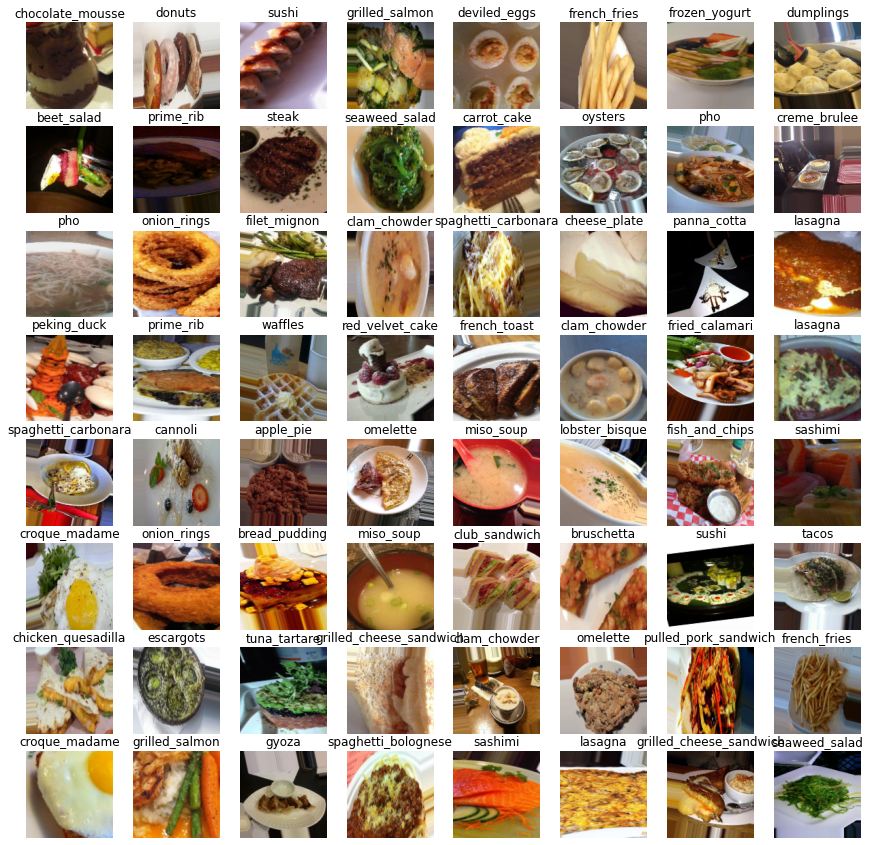

In [3]:
import matplotlib.pyplot as plt
import numpy as np
X, Y = train_generator.__getitem__(0)

classes = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(8, 8,figsize=(15,15))
for x in range(8):
    for y in range(8):
        axes[x][y].imshow((X[x*8 + y]).astype("uint8"))
        class_num = int(np.argmax(Y[x*8 + y]))
        class_name = classes[class_num]
        axes[x][y].title.set_text(class_name)
        axes[x][y].axis('off')

plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). This is a network optimized to have as little FLOPS for the maximum accuracy. The network can be downloaded with and without pre-trained weights. The pre-trained weights are trained on the [imageNet Challange](http://image-net.org/). These are nature image made with normale camera's of everyday objects (not just food).

In this notebook we are gone to see what a difference it makes to have pre-trained weights VS random weights.

The model that is loaded is without a head because we only have 101 classes not thousands.

In [4]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

def create_model(weights="imagenet"):
    n_classes = len(classes)
    pre_trained_model = EfficientNetB0(include_top=False, weights=weights)

    input_layer = pre_trained_model.input
    max_pool = MaxPooling2D((4, 4))(pre_trained_model.output)

    dense1 = Dense(n_classes, activation="softmax")(max_pool)
    flat = Flatten()(dense1)

    model = Model(input_layer, flat)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    return model

## Training with random weights
We train the model with randomly generated weights as a baseline to compare our pre-trained network against.

In [5]:
model_no_pretrain = create_model(None)
history_no_pretrained = model_no_pretrain.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/50
1105/1105 [==============================] - 700s 634ms/step - loss: 4.8597 - accuracy: 0.0132 - val_loss: 4.6524 - val_accuracy: 0.0179
Epoch 2/50
1105/1105 [==============================] - 629s 569ms/step - loss: 4.7384 - accuracy: 0.0202 - val_loss: 4.5526 - val_accuracy: 0.0219
Epoch 3/50
1105/1105 [==============================] - 621s 562ms/step - loss: 4.7289 - accuracy: 0.0226 - val_loss: 7.2331 - val_accuracy: 0.0101
Epoch 4/50
1105/1105 [==============================] - 621s 562ms/step - loss: 4.6925 - accuracy: 0.0280 - val_loss: 5.0427 - val_accuracy: 0.0314
Epoch 5/50
1105/1105 [==============================] - 620s 561ms/step - loss: 4.5848 - accuracy: 0.0395 - val_loss: 4.5075 - val_accuracy: 0.0374
Epoch 6/50
1105/1105 [==============================] - 619s 560ms/step - loss: 4.5162 - accuracy: 0.0475 - val_loss: 4.8426 - val_accuracy: 0.0452
Epoch 7/50
1105/1105 [==============================] - 621s 562ms/step - loss: 4.4788 - accuracy: 0.0562 - val_

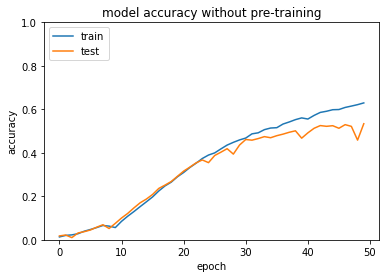

In [7]:
# summarize history for accuracy
plt.plot(history_no_pretrained.history['accuracy'])
plt.plot(history_no_pretrained.history['val_accuracy'])
plt.title('model accuracy without pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

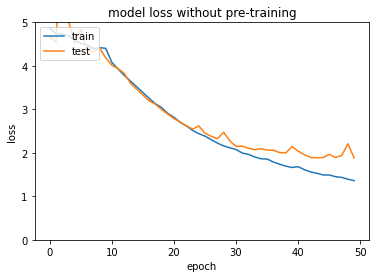

In [8]:
# summarize history for loss
plt.plot(history_no_pretrained.history['loss'])
plt.plot(history_no_pretrained.history['val_loss'])
plt.title('model loss without pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## training with pre-trained weights
Next up we load a new model but this time with pretrained weights.
Everything else about the model is exactly the same.

In [9]:
model_with_pretrain = create_model("imagenet")
history_pretrained = model_with_pretrain.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/50
1105/1105 [==============================] - 1148s 1s/step - loss: 2.4795 - accuracy: 0.4079 - val_loss: 1.9007 - val_accuracy: 0.5225
Epoch 2/50
1105/1105 [==============================] - 621s 562ms/step - loss: 1.7340 - accuracy: 0.5541 - val_loss: 1.7061 - val_accuracy: 0.5665
Epoch 3/50
1105/1105 [==============================] - 619s 560ms/step - loss: 1.5470 - accuracy: 0.5975 - val_loss: 1.6315 - val_accuracy: 0.5854
Epoch 4/50
1105/1105 [==============================] - 619s 560ms/step - loss: 1.4243 - accuracy: 0.6245 - val_loss: 1.5702 - val_accuracy: 0.6053
Epoch 5/50
1105/1105 [==============================] - 618s 560ms/step - loss: 1.3372 - accuracy: 0.6459 - val_loss: 1.5430 - val_accuracy: 0.6136
Epoch 6/50
1105/1105 [==============================] - 616s 558ms/step - loss: 1.2614 - accuracy: 0.6639 - val_loss: 1.4821 - val_accuracy: 0.6270
Epoch 7/50
1105/1105 [==============================] - 620s 561ms/step - loss: 1.1997 - accuracy: 0.6774 - val_lo

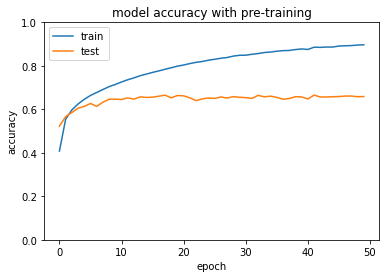

In [10]:
# summarize history for accuracy
plt.plot(history_pretrained.history['accuracy'])
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy with pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

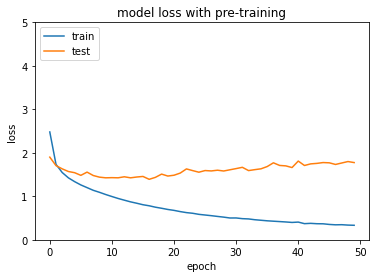

In [11]:
# summarize history for loss
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss with pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Conclusion
We can see the pre-trained model being at a better accuracy and loss for both validation and training after 3 epoch compared to 50 epoch if we don't pre-train.

We also see some danger, because the pre-trained model start overfitting way earlier.